<a href="https://colab.research.google.com/github/Jkimoon/2024F/blob/main/IO2_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyblp
# !pip install knitro

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 42.5 MB/s eta 0:00:00


In [ ]:
import pyblp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize
from pyblp import Optimization # Import Optimization class

pyblp.options.digits = 2
pyblp.options.verbose = False
pyblp.options.default_parallel = 3
pyblp.__version__

'1.1.0'

#Load Data

In [ ]:
# load data
product_data = pd.read_csv("airline_data_prepared.csv")
# Adjust 'simpleshare' based on the given conditions
# product_data['simpleshare'] = -0.000001
# If value is greater than or equal to 1, set it to 0.999999
# product_data.loc[product_data['simpleshare'] >= 1, 'simpleshare'] = 0.999999
# If value is 0, set it to 0.000001
# product_data.loc[product_data['simpleshare'] <= 0, 'simpleshare'] = 0.000001

#1.2 (simple IV)

In [ ]:
# Rename variables
product_data = product_data.rename(columns={'averageprice': 'prices'})
product_data = product_data.rename(columns={'market': 'market_ids'})
product_data = product_data.rename(columns={'airline_market_share': 'shares'})
product_data = product_data.rename(columns={'tkcarrier': 'firm_ids'})
# Rename IV's
product_data = product_data.rename(columns={'IV': 'demand_instruments0'})
product_data.head()

,market_ids,firm_ids,marketdistanceticket,OAGnonstop,origin,dest,airportmarketsize,prices,totalpassengers,market_nodirection,...,_est_iv_manual,_est_iv_dest,_est_iv_bres,_est_ols_fe,_est_iv_all,own_elasticity_iv,markup_iv,marginal_cost_iv,lerner_index_iv,residuals_iv
0,ACYATL,NK,0.677444,1.000000,ACY,ATL,6146834.5,0.773634,2200,ACYATL,...,1,1,1,1,1,-5.573799,0.138798,0.634835,0.179411,-2.235825
1,ACYDFW,NK,1.326746,0.000000,ACY,DFW,6883516.5,1.360923,140,ACYDFW,...,1,1,1,1,1,-9.808352,0.138751,1.222171,0.101954,-2.466400
2,ACYFLL,NK,0.978535,0.974646,ACY,FLL,6248623.5,0.757178,13410,ACYFLL,...,1,1,1,1,1,-5.445482,0.139047,0.618131,0.183638,-1.301249
3,ACYIAH,NK,1.342880,0.000000,ACY,IAH,6658437.5,1.381371,130,ACYIAH,...,1,1,1,1,1,-9.955731,0.138751,1.242619,0.100445,-2.399526
4,ACYLAS,NK,2.208158,0.000000,ACY,LAS,3761303.0,1.124277,190,ACYLAS,...,1,1,1,1,1,-8.102570,0.138756,0.985521,0.123418,-5.427683


In [ ]:
# set up problem
logit_formulation = pyblp.Formulation('prices + marketdistanceticket + AirlineOriginPresence', absorb='C(firm_ids)')
logit_formulation

prices + marketdistanceticket + AirlineOriginPresence + Absorb[C(firm_ids)]

In [ ]:
# display problem
problem = pyblp.Problem(logit_formulation, product_data)
problem

Dimensions:
 T      N     F    K1    MD    ED 
----  -----  ---  ----  ----  ----
4019  14315   8    3     3     1  

Formulations:
     Column Indices:          0              1                      2          
--------------------------  ------  --------------------  ---------------------
X1: Linear Characteristics  prices  marketdistanceticket  AirlineOriginPresence

In [ ]:
#solve problem
logit_results = problem.solve()
logit_results

Problem Results Summary:
GMM   Objective  Clipped  Weighting Matrix  Covariance Matrix
Step    Value    Shares   Condition Number  Condition Number 
----  ---------  -------  ----------------  -----------------
 2    +7.0E-25      0         +5.0E+01          +7.3E+02     

Cumulative Statistics:
Computation   Objective 
   Time      Evaluations
-----------  -----------
 00:00:00         2     

Beta Estimates (Robust SEs in Parentheses):
  prices    marketdistanceticket  AirlineOriginPresence
----------  --------------------  ---------------------
 -2.4E+01         +8.6E+00              +1.3E+00       
(+2.4E+00)       (+9.1E-01)            (+7.4E-01)      

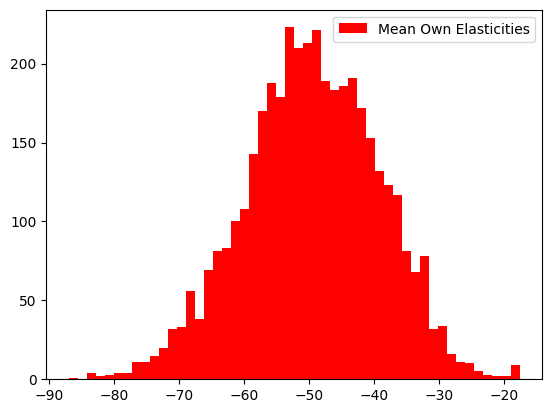

In [ ]:
#elasticities
elasticities = logit_results.compute_elasticities()
means = logit_results.extract_diagonal_means(elasticities)

plt.hist(
    [means.flatten()],
    color=['red'],
    bins=50
);
plt.legend(['Mean Own Elasticities']);

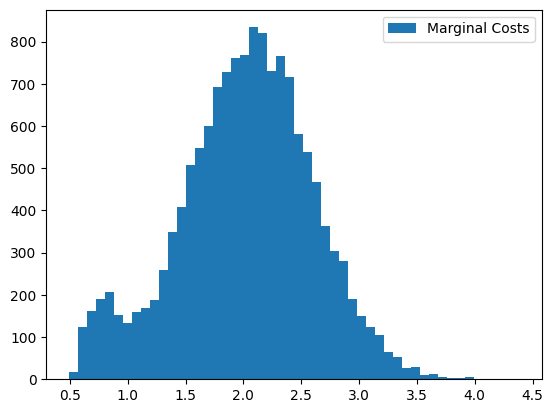

In [ ]:
# MC
costs = logit_results.compute_costs()
plt.hist(costs, bins=50);
plt.legend(["Marginal Costs"]);

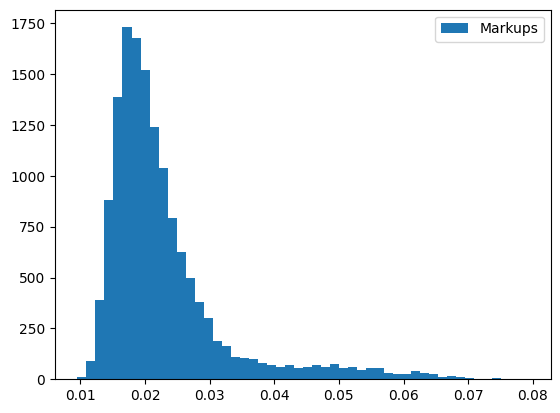

In [ ]:
markups = logit_results.compute_markups(costs=costs)
plt.hist(markups, bins=50);
plt.legend(["Markups"]);

# 1.2 (BR IV)

In [ ]:
# Rename variables
product_data = product_data.rename(columns={'averageprice': 'prices'})
product_data = product_data.rename(columns={'market': 'market_ids'})
product_data = product_data.rename(columns={'airline_market_share': 'shares'})
product_data = product_data.rename(columns={'tkcarrier': 'firm_ids'})
# Rename IV's
product_data = product_data.rename(columns={'IV_BR1': 'demand_instruments0'})
product_data = product_data.rename(columns={'IV_BR2': 'demand_instruments1'})
product_data.head()

,market_ids,firm_ids,marketdistanceticket,OAGnonstop,origin,dest,airportmarketsize,prices,totalpassengers,market_nodirection,...,_est_iv_manual,_est_iv_dest,_est_iv_bres,_est_ols_fe,_est_iv_all,own_elasticity_iv,markup_iv,marginal_cost_iv,lerner_index_iv,residuals_iv
0,ACYATL,NK,0.677444,1.000000,ACY,ATL,6146834.5,0.773634,2200,ACYATL,...,1,1,1,1,1,-5.573799,0.138798,0.634835,0.179411,-2.235825
1,ACYDFW,NK,1.326746,0.000000,ACY,DFW,6883516.5,1.360923,140,ACYDFW,...,1,1,1,1,1,-9.808352,0.138751,1.222171,0.101954,-2.466400
2,ACYFLL,NK,0.978535,0.974646,ACY,FLL,6248623.5,0.757178,13410,ACYFLL,...,1,1,1,1,1,-5.445482,0.139047,0.618131,0.183638,-1.301249
3,ACYIAH,NK,1.342880,0.000000,ACY,IAH,6658437.5,1.381371,130,ACYIAH,...,1,1,1,1,1,-9.955731,0.138751,1.242619,0.100445,-2.399526
4,ACYLAS,NK,2.208158,0.000000,ACY,LAS,3761303.0,1.124277,190,ACYLAS,...,1,1,1,1,1,-8.102570,0.138756,0.985521,0.123418,-5.427683


In [ ]:
# set up problem
logit_formulation = pyblp.Formulation('prices + marketdistanceticket + AirlineOriginPresence', absorb='C(firm_ids)')
logit_formulation

prices + marketdistanceticket + AirlineOriginPresence + Absorb[C(firm_ids)]

In [ ]:
# display problem
problem = pyblp.Problem(logit_formulation, product_data)
problem

Dimensions:
 T      N     F    K1    MD    ED 
----  -----  ---  ----  ----  ----
4019  14315   8    3     4     1  

Formulations:
     Column Indices:          0              1                      2          
--------------------------  ------  --------------------  ---------------------
X1: Linear Characteristics  prices  marketdistanceticket  AirlineOriginPresence

In [ ]:
#solve problem
logit_results = problem.solve()
logit_results

Problem Results Summary:
GMM   Objective  Clipped  Weighting Matrix  Covariance Matrix
Step    Value    Shares   Condition Number  Condition Number 
----  ---------  -------  ----------------  -----------------
 2    +2.7E+01      0         +2.1E+02          +1.2E+02     

Cumulative Statistics:
Computation   Objective 
   Time      Evaluations
-----------  -----------
 00:00:00         2     

Beta Estimates (Robust SEs in Parentheses):
  prices    marketdistanceticket  AirlineOriginPresence
----------  --------------------  ---------------------
 -4.9E+00         +1.6E+00              +4.3E+00       
(+2.2E-01)       (+8.7E-02)            (+1.6E-01)      

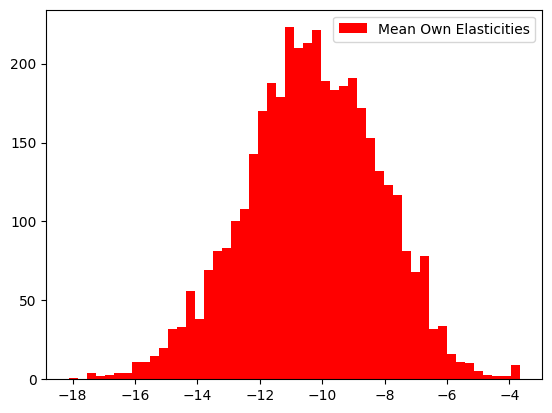

In [ ]:
#elasticities
elasticities = logit_results.compute_elasticities()
means = logit_results.extract_diagonal_means(elasticities)

plt.hist(
    [means.flatten()],
    color=['red'],
    bins=50
);
plt.legend(['Mean Own Elasticities']);

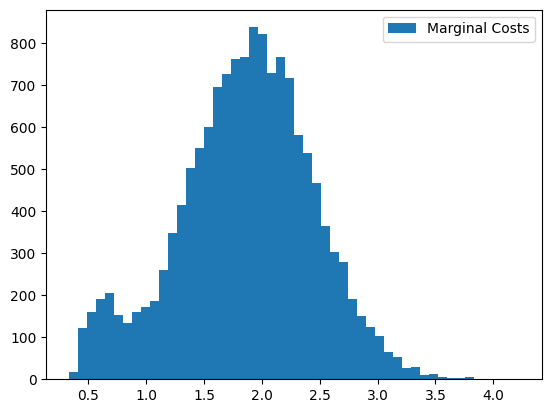

In [ ]:
# MC
costs = logit_results.compute_costs()
plt.hist(costs, bins=50);
plt.legend(["Marginal Costs"]);

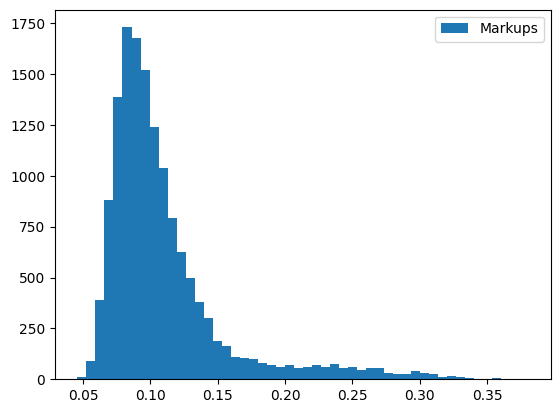

In [ ]:
markups = logit_results.compute_markups(costs=costs)
plt.hist(markups, bins=50);
plt.legend(["Markups"]);

# 1.3

In [ ]:
# prompt: construct a variable = 1/(1-shares) call it supply_x

# supply_x = 1 / (1 - product_data['shares'])


In [ ]:
product_data['supply_instruments0']	 = product_data['demand_instruments0']
product_data['supply_instruments1']	 = product_data['demand_instruments1']

In [ ]:
product_data[['demand_instruments0', 'demand_instruments1', 'supply_instruments0', 'supply_instruments1','totalpassengers']]

,demand_instruments0,demand_instruments1,supply_instruments0,supply_instruments1,totalpassengers
0,0.000000,1,0.000000,1,2200
1,0.000000,1,0.000000,1,140
2,0.000000,1,0.000000,1,13410
3,0.000000,1,0.000000,1,130
4,0.000000,1,0.000000,1,190
...,...,...,...,...,...
14310,2.666666,4,2.666666,4,1420
14311,2.460317,4,2.460317,4,1700
14312,2.492063,4,2.492063,4,1700
14313,2.571429,4,2.571429,4,17140


## long MC (no CRS)

In [ ]:
# long MC
product_data['sales'] = product_data['totalpassengers'] * product_data['prices']
product_formulations = (
   pyblp.Formulation('prices + marketdistanceticket + AirlineOriginPresence', absorb='C(firm_ids)'),
   None,
   pyblp.Formulation('marketdistanceticket + AirlineOriginPresence + AirlineDestinationPresence + log(sales)', absorb='C(firm_ids)')
)
product_formulations

(prices + marketdistanceticket + AirlineOriginPresence + Absorb[C(firm_ids)],
 None,
 marketdistanceticket + AirlineOriginPresence + AirlineDestinationPresence + log(sales) + Absorb[C(firm_ids)])

In [ ]:
problem_l = pyblp.Problem(product_formulations, product_data, costs_type='log')
problem_l

Initializing the problem ...
Absorbing demand-side fixed effects ...
Absorbing supply-side fixed effects ...
Initialized the problem after 00:00:00.

Dimensions:
 T      N     F    K1    K3    MD    MS    ED    ES 
----  -----  ---  ----  ----  ----  ----  ----  ----
4019  14315   8    3     4     4     6     1     1  

Formulations:
      Column Indices:                  0                      1                        2                   3     
----------------------------  --------------------  ---------------------  --------------------------  ----------
 X1: Linear Characteristics          prices         marketdistanceticket     AirlineOriginPresence               
X3: Log Cost Characteristics  marketdistanceticket  AirlineOriginPresence  AirlineDestinationPresence  log(sales)


Dimensions:
 T      N     F    K1    K3    MD    MS    ED    ES 
----  -----  ---  ----  ----  ----  ----  ----  ----
4019  14315   8    3     4     4     6     1     1  

Formulations:
      Column Indices:                  0                      1                        2                   3     
----------------------------  --------------------  ---------------------  --------------------------  ----------
 X1: Linear Characteristics          prices         marketdistanceticket     AirlineOriginPresence               
X3: Log Cost Characteristics  marketdistanceticket  AirlineOriginPresence  AirlineDestinationPresence  log(sales)

In [ ]:
beta_init = np.array([-4, 1.6, 4.3])
pyblp.options.verbose = True
# with pyblp.parallel(3):
# beta_bounds = ((-10, 0,0), (0, 5,5)),
results_l = problem_l.solve(beta=beta_init, optimization = Optimization('l-bfgs-b', {'ftol': 0, 'gtol': 1e-4}), method='2s')

Solving the problem ...

Beta Initial Values:
 prices   marketdistanceticket  AirlineOriginPresence
--------  --------------------  ---------------------
-4.0E+00        +1.6E+00              +4.3E+00       

Beta Lower Bounds:
 prices   marketdistanceticket  AirlineOriginPresence
--------  --------------------  ---------------------
  -INF            -INF                  -INF         

Beta Upper Bounds:
 prices   marketdistanceticket  AirlineOriginPresence
--------  --------------------  ---------------------
  +INF            +INF                  +INF         

Starting optimization ...

GMM   Computation  Optimization   Objective   Fixed Point  Contraction  Clipped  Objective   Objective   Gradient                              
Step     Time       Iterations   Evaluations  Iterations   Evaluations  Shares     Value    Improvement    Norm               Theta            
----  -----------  ------------  -----------  -----------  -----------  -------  ---------  -----------  -------

## Short MC

In [ ]:
# long MC
product_formulations = (
   pyblp.Formulation('prices + marketdistanceticket + AirlineOriginPresence', absorb='C(firm_ids)'),
   None,
   pyblp.Formulation('marketdistanceticket + AirlineOriginPresence + AirlineDestinationPresence', absorb='C(firm_ids)')
)
product_formulations

(prices + marketdistanceticket + AirlineOriginPresence + Absorb[C(firm_ids)],
 None,
 marketdistanceticket + AirlineOriginPresence + AirlineDestinationPresence + Absorb[C(firm_ids)])

In [ ]:
problem_s = pyblp.Problem(product_formulations, product_data, costs_type='log')
problem_s

Initializing the problem ...
Absorbing demand-side fixed effects ...
Absorbing supply-side fixed effects ...
Initialized the problem after 00:00:00.

Dimensions:
 T      N     F    K1    K3    MD    MS    ED    ES 
----  -----  ---  ----  ----  ----  ----  ----  ----
4019  14315   8    3     3     4     5     1     1  

Formulations:
      Column Indices:                  0                      1                        2             
----------------------------  --------------------  ---------------------  --------------------------
 X1: Linear Characteristics          prices         marketdistanceticket     AirlineOriginPresence   
X3: Log Cost Characteristics  marketdistanceticket  AirlineOriginPresence  AirlineDestinationPresence


Dimensions:
 T      N     F    K1    K3    MD    MS    ED    ES 
----  -----  ---  ----  ----  ----  ----  ----  ----
4019  14315   8    3     3     4     5     1     1  

Formulations:
      Column Indices:                  0                      1                        2             
----------------------------  --------------------  ---------------------  --------------------------
 X1: Linear Characteristics          prices         marketdistanceticket     AirlineOriginPresence   
X3: Log Cost Characteristics  marketdistanceticket  AirlineOriginPresence  AirlineDestinationPresence

In [ ]:
beta_init = np.array([-4, 1.6, 4.3])
pyblp.options.verbose = True
# with pyblp.parallel(3):
# beta_bounds = ((-10, 0,0), (0, 5,5)),
results_s = problem_s.solve(beta=beta_init, beta_bounds = ((-10, 0,0), (0, 5,5)), optimization = Optimization('l-bfgs-b', {'ftol': 0, 'gtol': 1e-4}), method='2s')

Solving the problem ...

Beta Initial Values:
 prices   marketdistanceticket  AirlineOriginPresence
--------  --------------------  ---------------------
-4.0E+00        +1.6E+00              +4.3E+00       

Beta Lower Bounds:
 prices   marketdistanceticket  AirlineOriginPresence
--------  --------------------  ---------------------
-1.0E+01        +0.0E+00              +0.0E+00       

Beta Upper Bounds:
 prices   marketdistanceticket  AirlineOriginPresence
--------  --------------------  ---------------------
+0.0E+00        +5.0E+00              +5.0E+00       

Starting optimization ...

GMM   Computation  Optimization   Objective   Fixed Point  Contraction  Clipped  Objective   Objective     Projected                                
Step     Time       Iterations   Evaluations  Iterations   Evaluations  Shares     Value    Improvement  Gradient Norm             Theta            
----  -----------  ------------  -----------  -----------  -----------  -------  ---------  ----------

# 1.4

In [ ]:
results = results_l


Computing elasticities with respect to prices ...
Finished after 00:00:02.

Extracting diagonal means ...
Finished after 00:00:01.



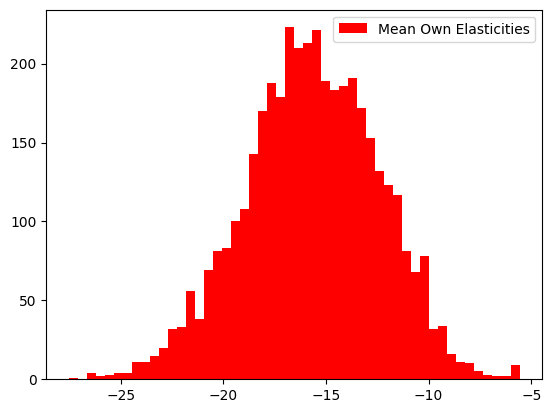

In [ ]:
#elasticities
elasticities = results.compute_elasticities()
means = results.extract_diagonal_means(elasticities)

plt.hist(
    [means.flatten()],
    color=['red'],
    bins=50
);
plt.legend(['Mean Own Elasticities']);

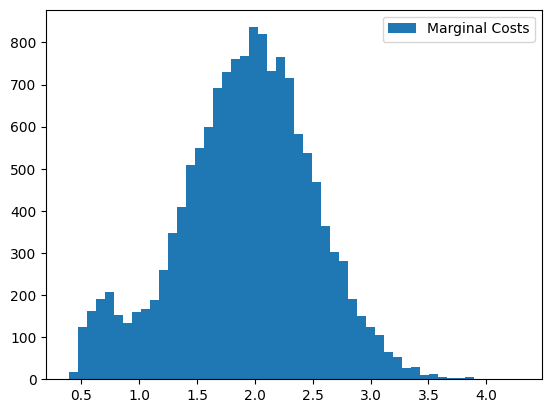

In [ ]:
# MC
# costs = results.compute_costs()
plt.hist(costs, bins=50);
plt.legend(["Marginal Costs"]);

Computing markups ...
Finished after 00:00:01.



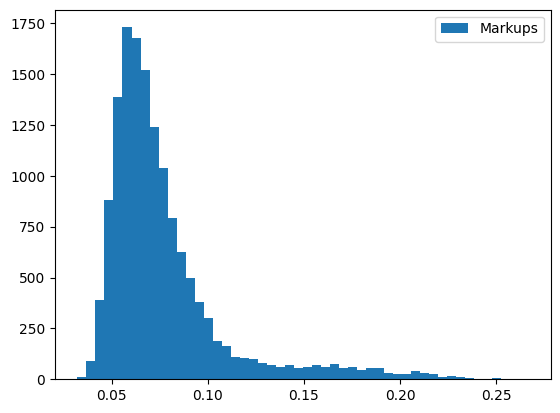

In [ ]:
markups = results.compute_markups(costs=costs)
plt.hist(markups, bins=50);
plt.legend(["Markups"]);

In [ ]:
hhi = results.compute_hhi()
costs = results.compute_costs()
profits = results.compute_profits(costs=costs)
cs = results.compute_consumer_surpluses()

Computing HHI ...
Finished after 00:00:02.

Computing marginal costs ...
Finished after 00:00:02.

Computing profits ...
Finished after 00:00:01.

Computing consumer surpluses with the equation that assumes away nonlinear income effects ...
Finished after 00:00:03.



In [ ]:
# merge between B6, NK
product_data['merger_ids'] = product_data['firm_ids'].replace('AA', 'DL')

In [ ]:
product_data['merger_ids'].describe()

,merger_ids
count,14315
unique,7
top,DL
freq,6838


In [ ]:
changed_prices = results.compute_prices(
    firm_ids=product_data['merger_ids'],
    costs=costs
)

Solving for equilibrium prices ...
Finished after 00:00:04.



In [ ]:
changed_shares =  results.compute_shares(changed_prices)

Computing shares ...
Finished after 00:00:02.



Computing HHI ...
Finished after 00:00:03.



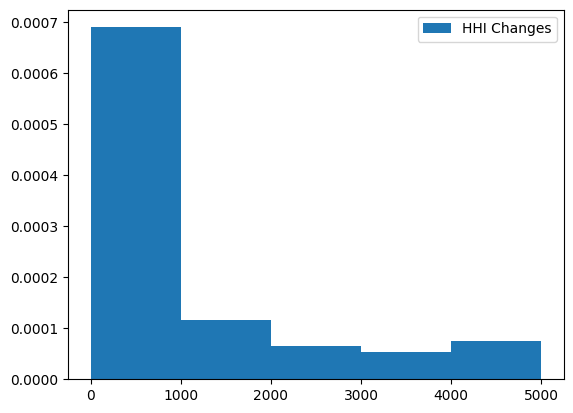

In [ ]:
changed_hhi = results.compute_hhi(
    firm_ids=product_data['merger_ids'],
    shares=changed_shares
)
plt.hist(changed_hhi - hhi, bins=5, density = True);
plt.legend(["HHI Changes"]);

Computing markups ...
Finished after 00:00:01.

Computing markups ...
Finished after 00:00:02.



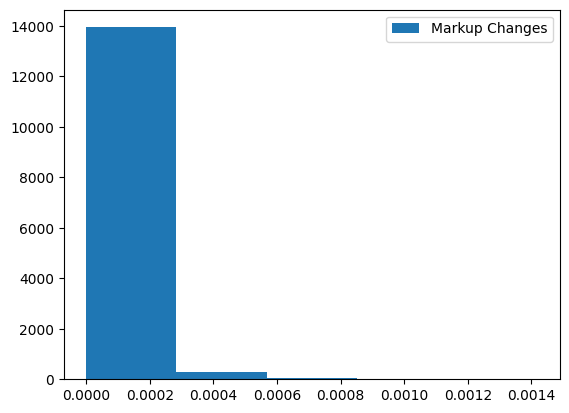

In [ ]:
changed_markups = results.compute_markups(changed_prices, costs)
markups = results.compute_markups(costs=costs)
plt.hist(changed_markups - markups, bins=5);
plt.legend(["Markup Changes"]);

Computing consumer surpluses with the equation that assumes away nonlinear income effects ...
Finished after 00:00:03.



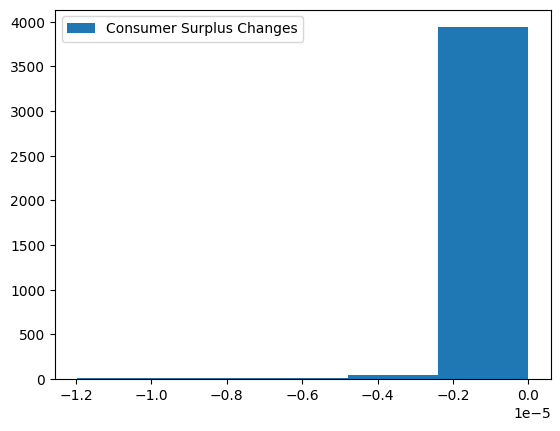

In [ ]:
changed_cs = results.compute_consumer_surpluses(changed_prices)
plt.hist(changed_cs - cs, bins=5);
plt.legend(["Consumer Surplus Changes"]);

#1.5

## Nevo with supply

In [ ]:
# RC long MC
product_data['sales'] = product_data['totalpassengers'] * product_data['prices']
product_formulations = (
   pyblp.Formulation('prices + marketdistanceticket + AirlineOriginPresence', absorb='C(firm_ids)'),
   pyblp.Formulation('1 + prices'),
   pyblp.Formulation('marketdistanceticket + AirlineOriginPresence + AirlineDestinationPresence', absorb='C(firm_ids)')
)
product_formulations

(prices + marketdistanceticket + AirlineOriginPresence + Absorb[C(firm_ids)],
 1 + prices,
 marketdistanceticket + AirlineOriginPresence + AirlineDestinationPresence + Absorb[C(firm_ids)])

In [ ]:
problem_rc_l = pyblp.Problem(product_formulations, product_data, integration=pyblp.Integration('halton', size=50), costs_type='log')
problem_rc_l

Initializing the problem ...
Absorbing demand-side fixed effects ...
Absorbing supply-side fixed effects ...
Initialized the problem after 00:00:10.

Dimensions:
 T      N     F     I      K1    K2    K3    MD    MS    ED    ES 
----  -----  ---  ------  ----  ----  ----  ----  ----  ----  ----
4019  14315   8   200950   3     2     3     4     5     1     1  

Formulations:
       Column Indices:                  0                      1                        2             
-----------------------------  --------------------  ---------------------  --------------------------
 X1: Linear Characteristics           prices         marketdistanceticket     AirlineOriginPresence   
X2: Nonlinear Characteristics           1                   prices                                    
X3: Log Cost Characteristics   marketdistanceticket  AirlineOriginPresence  AirlineDestinationPresence


Dimensions:
 T      N     F     I      K1    K2    K3    MD    MS    ED    ES 
----  -----  ---  ------  ----  ----  ----  ----  ----  ----  ----
4019  14315   8   200950   3     2     3     4     5     1     1  

Formulations:
       Column Indices:                  0                      1                        2             
-----------------------------  --------------------  ---------------------  --------------------------
 X1: Linear Characteristics           prices         marketdistanceticket     AirlineOriginPresence   
X2: Nonlinear Characteristics           1                   prices                                    
X3: Log Cost Characteristics   marketdistanceticket  AirlineOriginPresence  AirlineDestinationPresence

In [ ]:
beta_init = np.array([-4, 1.6, 4.3])
sigma_init =np.array([[0.1, 0.0],  # Random coefficient on constant
                [0.0, 0.2]])  # Random coefficient on price
pyblp.options.verbose = True
bfgs = pyblp.Optimization('bfgs', {'gtol': 1e-4})
# with pyblp.parallel(3):
# beta_bounds = ((-10, 0,0), (0, 5,5)),
results_rc_l = problem_rc_l.solve(beta=beta_init, sigma=sigma_init, optimization = bfgs)

Solving the problem ...

Nonlinear Coefficient Initial Values:
Sigma:     1       prices 
------  --------  --------
  1     +1.0E-01          
prices  +0.0E+00  +2.0E-01

Beta Initial Values:
 prices   marketdistanceticket  AirlineOriginPresence
--------  --------------------  ---------------------
-4.0E+00        +1.6E+00              +4.3E+00       

Nonlinear Coefficient Lower Bounds:
Sigma:     1       prices 
------  --------  --------
  1       -INF            
prices  +0.0E+00    -INF  

Beta Lower Bounds:
 prices   marketdistanceticket  AirlineOriginPresence
--------  --------------------  ---------------------
  -INF            -INF                  -INF         

Nonlinear Coefficient Upper Bounds:
Sigma:     1       prices 
------  --------  --------
  1       +INF            
prices  +0.0E+00    +INF  

Beta Upper Bounds:
 prices   marketdistanceticket  AirlineOriginPresence
--------  --------------------  ---------------------
  +INF            +INF                  +INF 

## Nevo demand only

In [ ]:
# product_data = product_data.rename(columns={'AirlineDestinationPresence': 'demand_instruments2'})
# Rename variables
product_data = product_data.rename(columns={'averageprice': 'prices'})
product_data = product_data.rename(columns={'market': 'market_ids'})
product_data = product_data.rename(columns={'airline_market_share': 'shares'})
product_data = product_data.rename(columns={'tkcarrier': 'firm_ids'})
# Rename IV's
product_data = product_data.rename(columns={'IV_BR1': 'demand_instruments0'})
product_data = product_data.rename(columns={'IV_BR2': 'demand_instruments1'})
product_data = product_data.rename(columns={'IV': 'demand_instruments2'})
# product_data = product_data.rename(columns={'IV_BR2': 'demand_instruments1'})

In [ ]:
# RC long MC
product_data['sales'] = product_data['totalpassengers'] * product_data['prices']
product_formulations = (
   pyblp.Formulation('prices + marketdistanceticket + AirlineOriginPresence', absorb='C(firm_ids)'),
   pyblp.Formulation('1 + prices')
)
product_formulations

(prices + marketdistanceticket + AirlineOriginPresence + Absorb[C(firm_ids)],
 1 + prices)

In [ ]:
problem_rc_d = pyblp.Problem(product_formulations, product_data, integration=pyblp.Integration('halton', size=20), costs_type='log')
problem_rc_d

Initializing the problem ...
Absorbing demand-side fixed effects ...
Initialized the problem after 00:00:09.

Dimensions:
 T      N     F     I     K1    K2    MD    ED 
----  -----  ---  -----  ----  ----  ----  ----
4019  14315   8   80380   3     2     5     1  

Formulations:
       Column Indices:           0              1                      2          
-----------------------------  ------  --------------------  ---------------------
 X1: Linear Characteristics    prices  marketdistanceticket  AirlineOriginPresence
X2: Nonlinear Characteristics    1            prices                              


Dimensions:
 T      N     F     I     K1    K2    MD    ED 
----  -----  ---  -----  ----  ----  ----  ----
4019  14315   8   80380   3     2     5     1  

Formulations:
       Column Indices:           0              1                      2          
-----------------------------  ------  --------------------  ---------------------
 X1: Linear Characteristics    prices  marketdistanceticket  AirlineOriginPresence
X2: Nonlinear Characteristics    1            prices                              

In [ ]:
beta_init = np.array([-4, 1.6, 4.3])
sigma_init =np.array([[0.1, 0.0],  # Random coefficient on constant
                [0.0, 0.2]])  # Random coefficient on price
pyblp.options.verbose = True
bfgs = pyblp.Optimization('bfgs', {'gtol': 1e-4})
# with pyblp.parallel(3):
# beta_bounds = ((-10, 0,0), (0, 5,5)),
# Optimization('l-bfgs-b', {'ftol': 0, 'gtol': 1e-4})
results_rc_d = problem_rc_d.solve(beta=beta_init, sigma=sigma_init, optimization = bfgs)

Solving the problem ...

Nonlinear Coefficient Initial Values:
Sigma:     1       prices 
------  --------  --------
  1     +1.0E-01          
prices  +0.0E+00  +2.0E-01

Beta Initial Values:
 prices   marketdistanceticket  AirlineOriginPresence
--------  --------------------  ---------------------
-4.0E+00        +1.6E+00              +4.3E+00       

Nonlinear Coefficient Lower Bounds:
Sigma:     1       prices 
------  --------  --------
  1       -INF            
prices  +0.0E+00    -INF  

Beta Lower Bounds:
 prices   marketdistanceticket  AirlineOriginPresence
--------  --------------------  ---------------------
  -INF            -INF                  -INF         

Nonlinear Coefficient Upper Bounds:
Sigma:     1       prices 
------  --------  --------
  1       +INF            
prices  +0.0E+00    +INF  

Beta Upper Bounds:
 prices   marketdistanceticket  AirlineOriginPresence
--------  --------------------  ---------------------
  +INF            +INF                  +INF 

##merger


In [ ]:
results = results_rc_d


In [ ]:
results

Problem Results Summary:
GMM   Objective  Gradient      Hessian         Hessian     Clipped  Weighting Matrix  Covariance Matrix
Step    Value      Norm    Min Eigenvalue  Max Eigenvalue  Shares   Condition Number  Condition Number 
----  ---------  --------  --------------  --------------  -------  ----------------  -----------------
 2    +2.6E+01   +2.7E-05     +1.7E+00        +4.2E+03        0         +2.1E+02          +2.0E+17     

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective   Fixed Point  Contraction
   Time      Converged   Iterations   Evaluations  Iterations   Evaluations
-----------  ---------  ------------  -----------  -----------  -----------
 00:11:44       Yes          30           40         285822       946913   

Nonlinear Coefficient Estimates (Robust SEs in Parentheses):
Sigma:      1         prices  
------  ----------  ----------
  1      +2.5E-01             
        (+8.6E-03)            
                              
prices   +0.0E

In [ ]:
costs = results.compute_costs()
markups = results.compute_markups(costs=costs)
hhi = results.compute_hhi()
profits = results.compute_profits(costs=costs)
cs = results.compute_consumer_surpluses()

Computing marginal costs ...
Finished after 00:00:03.

Computing markups ...
Finished after 00:00:01.

Computing HHI ...
Finished after 00:00:02.

Computing profits ...
Finished after 00:00:02.

Computing consumer surpluses with the equation that assumes away nonlinear income effects ...
Finished after 00:00:03.



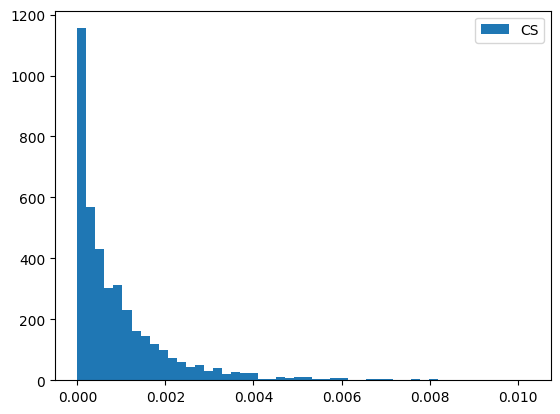

In [ ]:
plt.hist(cs, bins=50);
plt.legend(["CS"]);

In [ ]:
# merge between B6, NK
# Identify markets where both NK and B6 are present
shared_markets = product_data.groupby("market_ids")["firm_ids"].unique()
shared_markets = shared_markets[shared_markets.apply(lambda firms: "B6" in firms and "NK" in firms)].index

In [ ]:
# Simulate the merger: assign NK the same firm ID as B6
product_data["merger_ids"] = product_data["firm_ids"].replace('B6', 'NK')

In [ ]:
# Compute new equilibrium prices, shares, HHI, and markups for all markets
changed_prices = results.compute_prices(firm_ids=product_data['merger_ids'], costs=costs)
changed_shares = results.compute_shares(changed_prices)
changed_hhi = results.compute_hhi(firm_ids=product_data['merger_ids'], shares=changed_shares)
changed_markups = results.compute_markups(changed_prices, costs)
changed_cs = results.compute_consumer_surpluses(changed_prices)

Solving for equilibrium prices ...
Finished after 00:00:04.

Computing shares ...
Finished after 00:00:02.

Computing HHI ...
Finished after 00:00:02.

Computing markups ...
Finished after 00:00:01.

Computing consumer surpluses with the equation that assumes away nonlinear income effects ...
Finished after 00:00:03.



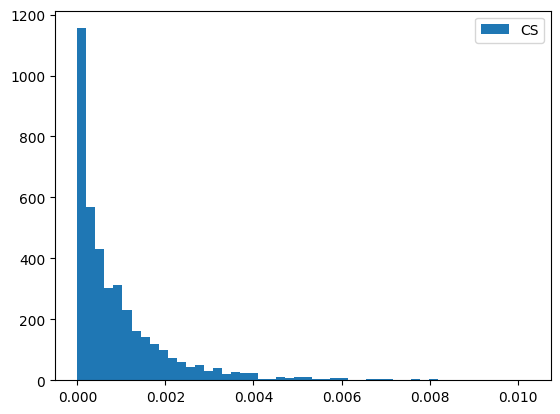

In [ ]:
plt.hist(changed_cs, bins=50);
plt.legend(["CS"]);

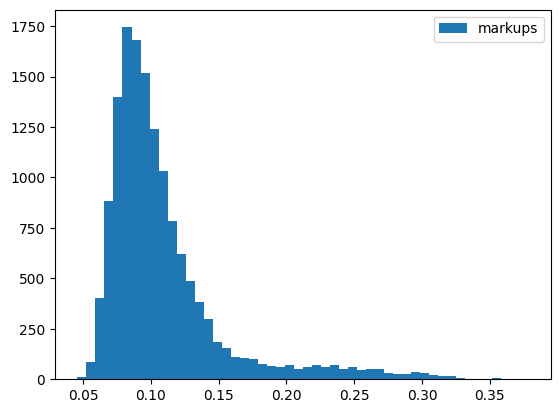

In [ ]:
plt.hist(markups, bins=50);
plt.legend(["markups"]);

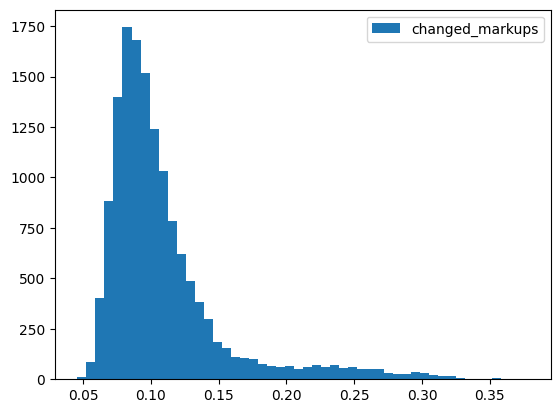

In [ ]:
plt.hist(changed_markups, bins=50);
plt.legend(["changed_markups"]);

In [ ]:
# Convert NumPy arrays to Pandas Series with market IDs as index (flattening the arrays)
changed_markups = pd.Series(changed_markups.flatten(), index=product_data["market_ids"])
markups = pd.Series(markups.flatten(), index=product_data["market_ids"])

changed_cs = pd.Series(changed_cs.flatten(), index=product_data["market_ids"].unique())
cs = pd.Series(cs.flatten(), index=product_data["market_ids"].unique())

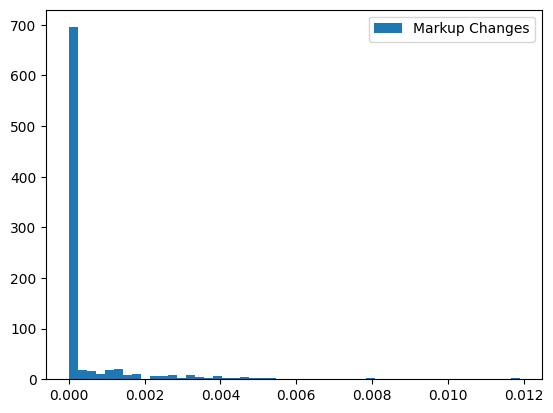

In [ ]:
# changed_markups = results.compute_markups(changed_prices, costs)
# markups = results.compute_markups(costs=costs)
filtered_markups = changed_markups.loc[shared_markets] - markups.loc[shared_markets]
per_change_markups = filtered_markups / markups.loc[shared_markets]
plt.hist(per_change_markups, bins=50);
plt.legend(["Markup Changes"]);

In [ ]:
# CS
filtered_cs = changed_cs.loc[shared_markets] - cs.loc[shared_markets]
per_change_cs = filtered_cs / cs.loc[shared_markets]

In [ ]:
filtered_cs

,0
market_ids,
ATLBOS,-1.274734e-06
ATLEWR,-1.316661e-09
ATLFLL,-1.114389e-06
ATLLAX,-4.615692e-09
ATLMCO,-3.852674e-07
...,...
SEAEWR,-8.831602e-11
SEAPHL,-3.953321e-09
TPABDL,-1.209355e-07


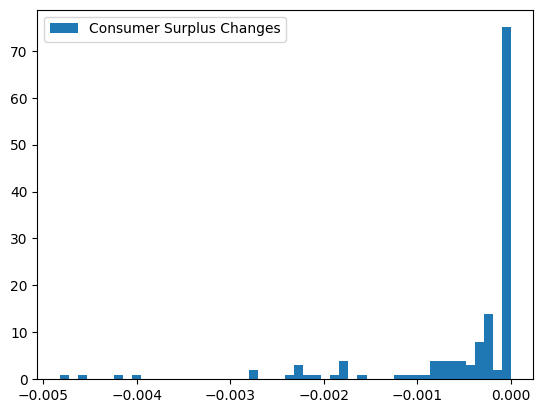

In [ ]:
plt.hist(per_change_cs, bins=50);
plt.legend(["Consumer Surplus Changes"]);

### merger big

In [ ]:
# merge between DL, AA
shared_markets = product_data.groupby("market_ids")["firm_ids"].unique()
shared_markets = shared_markets[shared_markets.apply(lambda firms: "DL" in firms and "AA" in firms)].index

In [ ]:
# Simulate the merger: assign NK the same firm ID as B6
product_data["merger_ids"] = product_data["firm_ids"].replace('DL', 'AA')

In [ ]:
# Compute new equilibrium prices, shares, HHI, and markups for all markets
changed_pricesb = results.compute_prices(firm_ids=product_data['merger_ids'], costs=costs)
changed_sharesb = results.compute_shares(changed_pricesb)
changed_hhib = results.compute_hhi(firm_ids=product_data['merger_ids'], shares=changed_sharesb)
changed_markupsb = results.compute_markups(changed_pricesb, costs)
changed_csb = results.compute_consumer_surpluses(changed_pricesb)

Solving for equilibrium prices ...
Finished after 00:00:05.

Computing shares ...
Finished after 00:00:02.

Computing HHI ...
Finished after 00:00:03.

Computing markups ...
Finished after 00:00:01.

Computing consumer surpluses with the equation that assumes away nonlinear income effects ...
Finished after 00:00:04.



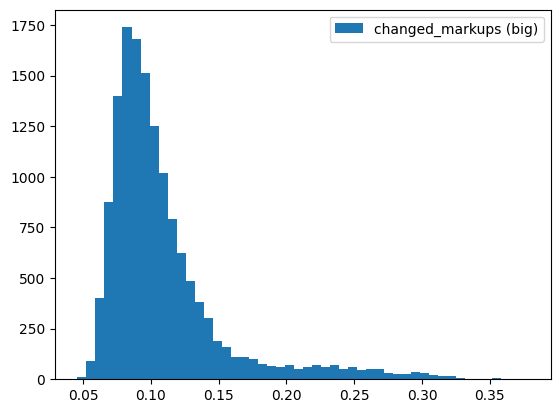

In [ ]:
plt.hist(changed_markupsb, bins=50);
plt.legend(["changed_markups (big)"]);

In [ ]:
# Convert NumPy arrays to Pandas Series with market IDs as index (flattening the arrays)
changed_markupsb = pd.Series(changed_markupsb.flatten(), index=product_data["market_ids"])
# markups = pd.Series(markups.flatten(), index=product_data["market_ids"])

changed_csb = pd.Series(changed_csb.flatten(), index=product_data["market_ids"].unique())
# cs = pd.Series(cs.flatten(), index=product_data["market_ids"].unique())

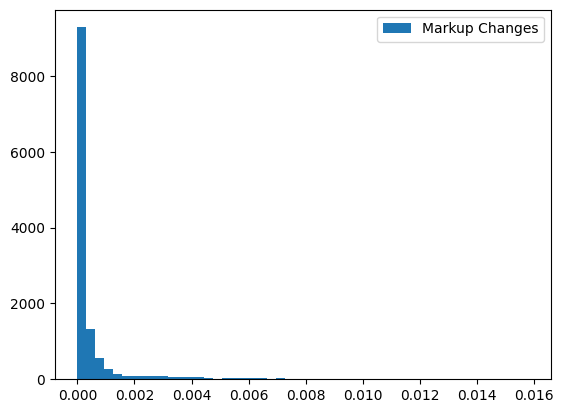

In [ ]:
# changed_markups = results.compute_markups(changed_prices, costs)
# markups = results.compute_markups(costs=costs)
filtered_markupsb = changed_markupsb.loc[shared_markets] - markups.loc[shared_markets]
per_change_markupsb = filtered_markupsb / markups.loc[shared_markets]
plt.hist(per_change_markupsb, bins=50);
plt.legend(["Markup Changes"]);

In [ ]:
# CS
filtered_csb = changed_csb.loc[shared_markets] - cs.loc[shared_markets]
per_change_csb = filtered_csb / cs.loc[shared_markets]

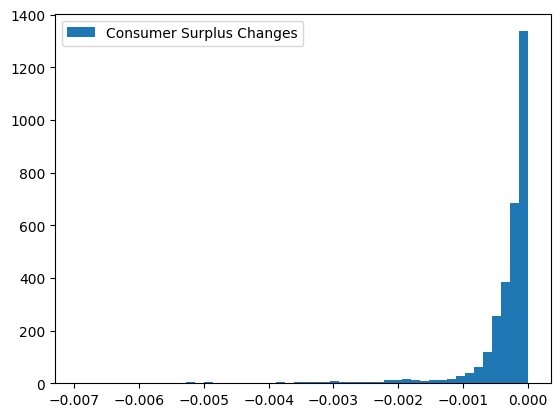

In [ ]:
plt.hist(per_change_csb, bins=50);
plt.legend(["Consumer Surplus Changes"]);

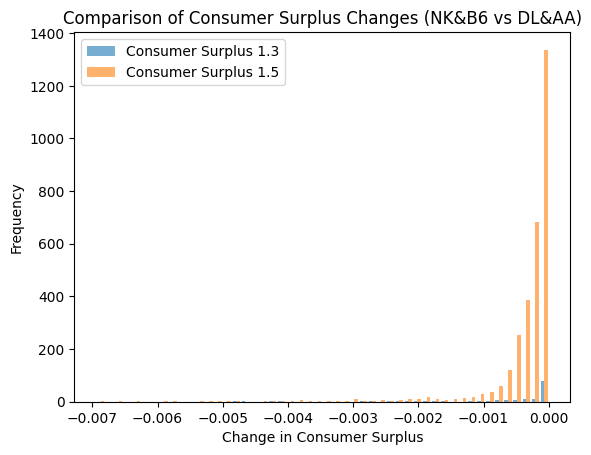

In [ ]:
# Plot both histograms in one figure
plt.hist([per_change_cs, per_change_csb], bins=50, alpha=0.6, label=["Consumer Surplus 1.3", "Consumer Surplus 1.5"])

# Add legend and labels
plt.legend()
plt.xlabel("Change in Consumer Surplus")
plt.ylabel("Frequency")
plt.title("Comparison of Consumer Surplus Changes (NK&B6 vs DL&AA)")

# Show the plot
plt.show()


## merger 1.3

In [ ]:
# Compute new equilibrium prices, shares, HHI, and markups for all markets
# results = results_l


In [ ]:
costs13 = results_l.compute_costs()
markups13 = results_l.compute_markups(costs=costs13)
hhi13 = results_l.compute_hhi()
profits13 = results_l.compute_profits(costs=costs13)
cs13 = results_l.compute_consumer_surpluses()

Computing marginal costs ...
Finished after 00:00:03.

Computing markups ...
Finished after 00:00:01.

Computing HHI ...
Finished after 00:00:02.

Computing profits ...
Finished after 00:00:01.

Computing consumer surpluses with the equation that assumes away nonlinear income effects ...
Finished after 00:00:04.



In [ ]:
# merge between B6, NK
# Identify markets where both NK and B6 are present
shared_markets = product_data.groupby("market_ids")["firm_ids"].unique()
shared_markets = shared_markets[shared_markets.apply(lambda firms: "B6" in firms and "NK" in firms)].index

# Keep only these markets in the dataset
# product_data_filtered = product_data[product_data["market_ids"].isin(shared_markets)]

# product_data_filtered

In [ ]:
# Simulate the merger: assign NK the same firm ID as B6
product_data["merger_ids"] = product_data["firm_ids"].replace({"B6": "NK"})


In [ ]:
# Compute new equilibrium prices, shares, HHI, and markups for all markets
changed_prices13 = results_l.compute_prices(firm_ids=product_data['merger_ids'], costs=costs13)
changed_shares13 = results_l.compute_shares(changed_prices13)
changed_hhi13 = results_l.compute_hhi(firm_ids=product_data['merger_ids'], shares=changed_shares13)
changed_markups13 = results_l.compute_markups(changed_prices13, costs13)
changed_cs13 = results_l.compute_consumer_surpluses(changed_prices13)

Solving for equilibrium prices ...
Finished after 00:00:03.

Computing shares ...
Finished after 00:00:03.

Computing HHI ...
Finished after 00:00:03.

Computing markups ...
Finished after 00:00:01.

Computing consumer surpluses with the equation that assumes away nonlinear income effects ...
Finished after 00:00:04.



In [ ]:
# Convert NumPy arrays to Pandas Series with market IDs as index (flattening the arrays)
changed_markups13 = pd.Series(changed_markups13.flatten(), index=product_data["market_ids"])
markups13 = pd.Series(markups13.flatten(), index=product_data["market_ids"])

changed_cs13 = pd.Series(changed_cs13.flatten(), index=product_data["market_ids"].unique())
cs13 = pd.Series(cs13.flatten(), index=product_data["market_ids"].unique())

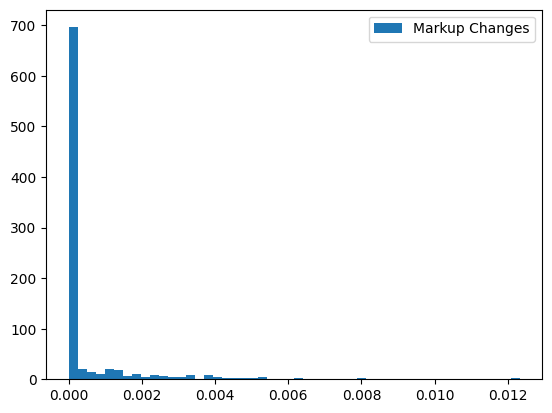

In [ ]:
# changed_markups = results.compute_markups(changed_prices, costs)
# markups = results.compute_markups(costs=costs)
filtered_markups13 = changed_markups13.loc[shared_markets] - markups13.loc[shared_markets]
per_change_markups13 = filtered_markups13 / markups13.loc[shared_markets]
plt.hist(per_change_markups13, bins=50);
plt.legend(["Markup Changes"]);

In [ ]:
# Now filtering works correctly
filtered_cs13 = changed_cs13.loc[shared_markets] - cs13.loc[shared_markets]
per_change_cs13 = filtered_cs13 / cs13.loc[shared_markets]

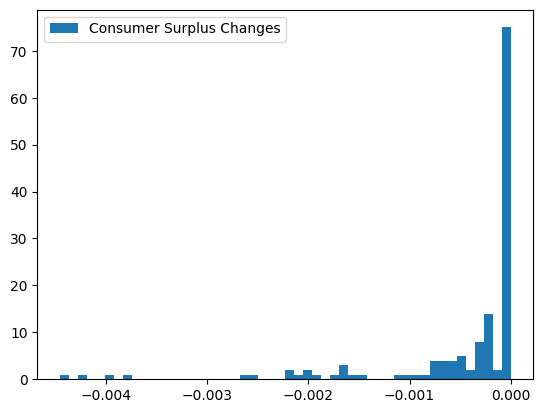

In [ ]:
plt.hist(per_change_cs13, bins=50);
plt.legend(["Consumer Surplus Changes"]);

### merger big 13

In [ ]:
# merge between B6, NK
# Identify markets where both NK and B6 are present
shared_markets = product_data.groupby("market_ids")["firm_ids"].unique()
shared_markets = shared_markets[shared_markets.apply(lambda firms: "DL" in firms and "AA" in firms)].index

# Keep only these markets in the dataset
# product_data_filtered = product_data[product_data["market_ids"].isin(shared_markets)]

# product_data_filtered

In [ ]:
# Simulate the merger: assign NK the same firm ID as B6
product_data["merger_ids"] = product_data["firm_ids"].replace({"DL": "AA"})


In [ ]:
# Compute new equilibrium prices, shares, HHI, and markups for all markets
changed_prices13b = results_l.compute_prices(firm_ids=product_data['merger_ids'], costs=costs13)
changed_shares13b = results_l.compute_shares(changed_prices13b)
changed_hhi13b = results_l.compute_hhi(firm_ids=product_data['merger_ids'], shares=changed_shares13b)
changed_markups13b = results_l.compute_markups(changed_prices13b, costs13)
changed_cs13b = results_l.compute_consumer_surpluses(changed_prices13b)

Solving for equilibrium prices ...
Finished after 00:00:05.

Computing shares ...
Finished after 00:00:02.

Computing HHI ...
Finished after 00:00:04.

Computing markups ...
Finished after 00:00:01.

Computing consumer surpluses with the equation that assumes away nonlinear income effects ...
Finished after 00:00:04.



In [ ]:
# Convert NumPy arrays to Pandas Series with market IDs as index (flattening the arrays)
changed_markups13b = pd.Series(changed_markups13b.flatten(), index=product_data["market_ids"])
# markups13b = pd.Series(markups13.flatten(), index=product_data["market_ids"])

changed_cs13b = pd.Series(changed_cs13b.flatten(), index=product_data["market_ids"].unique())
# cs13b = pd.Series(cs13.flatten(), index=product_data["market_ids"].unique())

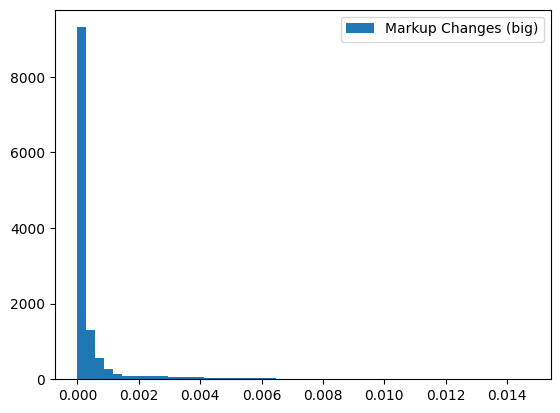

In [ ]:
# changed_markups = results.compute_markups(changed_prices, costs)
# markups = results.compute_markups(costs=costs)
filtered_markups13b = changed_markups13b.loc[shared_markets] - markups13.loc[shared_markets]
per_change_markups13b = filtered_markups13b / markups13.loc[shared_markets]
plt.hist(per_change_markups13b, bins=50);
plt.legend(["Markup Changes (big)"]);

In [ ]:
# Now filtering works correctly
filtered_cs13b = changed_cs13b.loc[shared_markets] - cs13.loc[shared_markets]
per_change_cs13b = filtered_cs13b / cs13.loc[shared_markets]

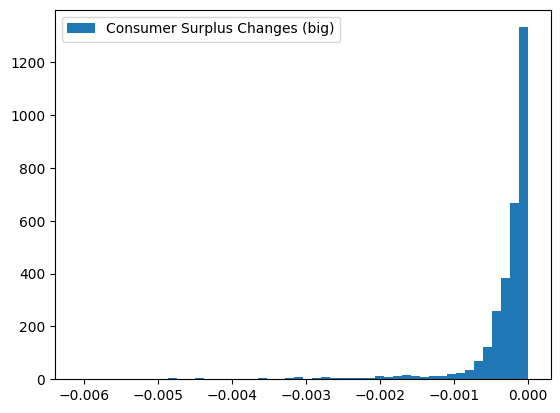

In [ ]:
plt.hist(per_change_cs13b, bins=50);
plt.legend(["Consumer Surplus Changes (big)"]);

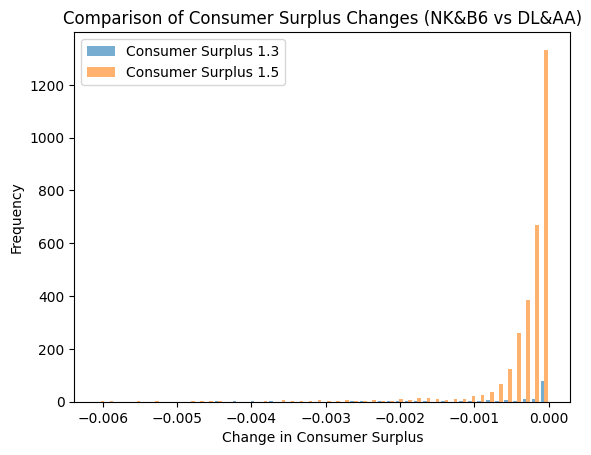

In [ ]:
# Plot both histograms in one figure
plt.hist([per_change_cs13, per_change_cs13b], bins=50, alpha=0.6, label=["Consumer Surplus 1.3", "Consumer Surplus 1.5"])

# Add legend and labels
plt.legend()
plt.xlabel("Change in Consumer Surplus")
plt.ylabel("Frequency")
plt.title("Comparison of Consumer Surplus Changes (NK&B6 vs DL&AA)")

# Show the plot
plt.show()


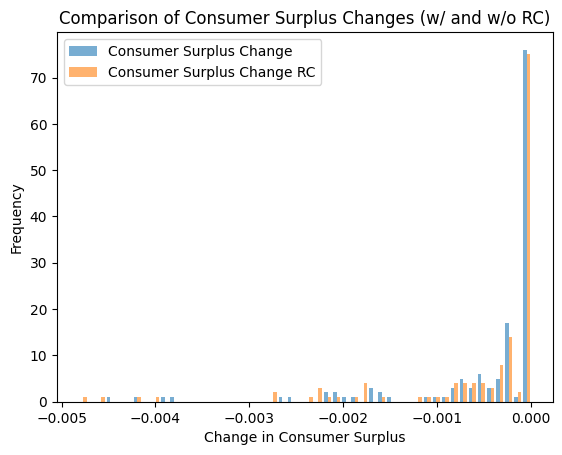

In [ ]:
# Plot both histograms in one figure
plt.hist([per_change_cs13, per_change_cs], bins=50, alpha=0.6, label=["Consumer Surplus Change", "Consumer Surplus Change RC"])

# Add legend and labels
plt.legend()
plt.xlabel("Change in Consumer Surplus")
plt.ylabel("Frequency")
plt.title("Comparison of Consumer Surplus Changes (w/ and w/o RC)")

# Show the plot
plt.show()


In [ ]:
# Save linear model results
#results_l.to_pickle("results_l.pkl")

# Save RC model results
#results_rc_d.to_pickle("results_rc_d.pkl")

results_s.to_pickle("results.pkl")


In [ ]:

results_l_loaded = pd.read_pickle("results_l.pkl")
results_rc_d_loaded = pd.read_pickle("results_rc_d.pkl")


In [ ]:
results_l_loaded

Problem Results Summary:
GMM   Objective  Gradient      Hessian         Hessian     Clipped  Weighting Matrix  Covariance Matrix
Step    Value      Norm    Min Eigenvalue  Max Eigenvalue  Shares   Condition Number  Condition Number 
----  ---------  --------  --------------  --------------  -------  ----------------  -----------------
 2    +3.0E+02   +1.3E-05     +7.2E+01        +4.1E+03        0         +4.7E+04          +6.1E+04     

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective 
   Time      Converged   Iterations   Evaluations
-----------  ---------  ------------  -----------
 00:07:16       Yes          17           24     

Beta Estimates (Robust SEs in Parentheses):
  prices    marketdistanceticket  AirlineOriginPresence
----------  --------------------  ---------------------
 -7.5E+00         +2.6E+00              +3.9E+00       
(+1.8E-01)       (+7.5E-02)            (+2.1E-01)      

Gamma Estimates (Robust SEs in Parentheses):
marketdistanceticket